In [1]:
import time
import serial
import firebase_admin
from firebase_admin import credentials, db

SERIAL_PORT = "COM10"   
BAUD_RATE   = 9600
DB_URL      = "https://project-2f3d3-default-rtdb.firebaseio.com/"
DB_PATH     = "gyro_data"

cred = credentials.Certificate("pro.json")
firebase_admin.initialize_app(cred, {"databaseURL": DB_URL})
ref = db.reference(DB_PATH)

s = serial.Serial(SERIAL_PORT, BAUD_RATE, timeout=2)

print("Listening on serial and uploading to Firebase... (Ctrl+C to stop)")
try:
    while True:
        line = s.readline().decode(errors="ignore").strip()
        if not line or line.lower().startswith("gx"):
            continue
        try:
            gx, gy, gz = map(float, line.split(","))
            payload = {
                "timestamp": time.time(),
                "x": gx,
                "y": gy,
                "z": gz
            }
            ref.push(payload)
            print("Uploaded:", payload)
        except ValueError:
            continue
except KeyboardInterrupt:
    print("Stopped by user.")
finally:
    s.close()


Listening on serial and uploading to Firebase... (Ctrl+C to stop)
Uploaded: {'timestamp': 1755753538.7396781, 'x': -0.610352, 'y': 0.244141, 'z': 0.061035}
Uploaded: {'timestamp': 1755753539.671472, 'x': -0.610352, 'y': 0.244141, 'z': 0.061035}
Uploaded: {'timestamp': 1755753539.9128716, 'x': -0.671387, 'y': 0.244141, 'z': 0.061035}
Uploaded: {'timestamp': 1755753540.1445417, 'x': -0.610352, 'y': 0.183105, 'z': 0.0}
Uploaded: {'timestamp': 1755753540.4242365, 'x': -0.610352, 'y': 0.183105, 'z': 0.061035}
Uploaded: {'timestamp': 1755753540.6889064, 'x': -0.671387, 'y': 0.183105, 'z': 0.061035}
Uploaded: {'timestamp': 1755753540.9173353, 'x': -0.671387, 'y': 0.244141, 'z': 0.061035}
Uploaded: {'timestamp': 1755753541.1429653, 'x': -0.610352, 'y': 0.244141, 'z': 0.061035}
Uploaded: {'timestamp': 1755753541.3765173, 'x': -0.671387, 'y': 0.244141, 'z': 0.061035}
Uploaded: {'timestamp': 1755753541.6022096, 'x': -0.671387, 'y': 0.244141, 'z': 0.061035}
Uploaded: {'timestamp': 1755753541.85413

In [2]:
import csv
import firebase_admin
from firebase_admin import credentials, db

DB_URL  = "https://project-2f3d3-default-rtdb.firebaseio.com/"
DB_PATH = "gyro_data"
OUT_CSV = "gyro_data_raw.csv"

try:
    firebase_admin.get_app()
except ValueError:
    cred = credentials.Certificate("pro.json")
    firebase_admin.initialize_app(cred, {"databaseURL": DB_URL})

ref = db.reference(DB_PATH)
data = ref.get()
rows = []
if data:
    for key, sample in data.items():
        rows.append(sample)

rows.sort(key=lambda r: r.get("timestamp", 0))

with open(OUT_CSV, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["timestamp","x","y","z"])
    for r in rows:
        writer.writerow([r.get("timestamp",""), r.get("x",""), r.get("y",""), r.get("z","")])

print(f"Exported {len(rows)} samples to {OUT_CSV}")


Exported 979 samples to gyro_data_raw.csv


Saved graphs: graph_x.png, graph_y.png, graph_z.png, graph_all.png


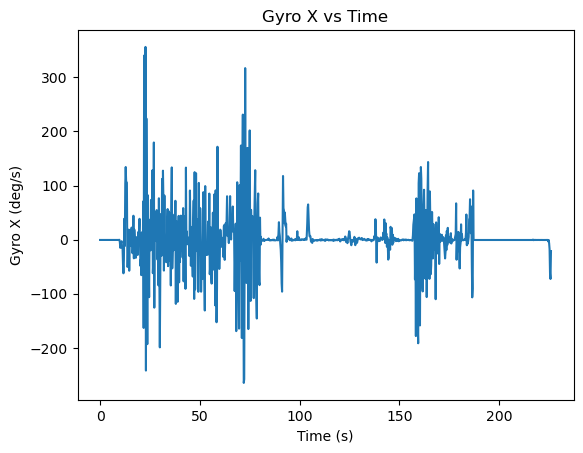

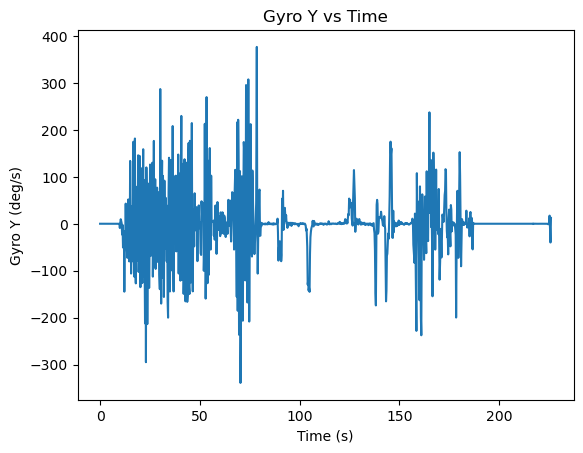

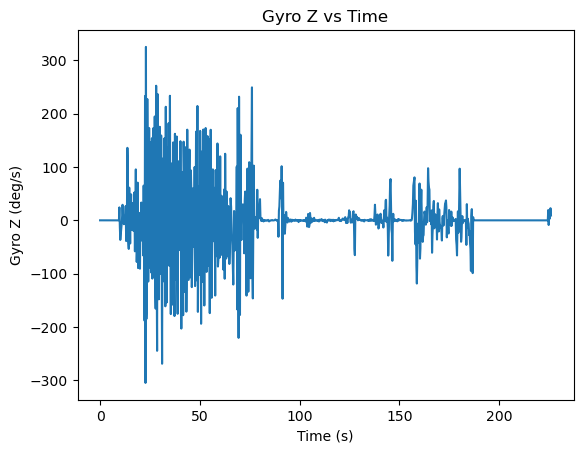

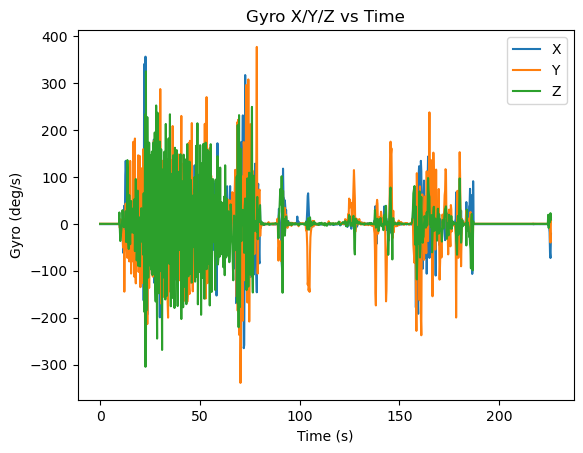

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

RAW_CSV   = "gyro_data_raw.csv"
CLEAN_CSV = "gyro_data_clean.csv"

# Load data
df = pd.read_csv(RAW_CSV)

# Drop missing/invalid rows
df = df.dropna()
df = df.apply(pd.to_numeric, errors="coerce")
df = df.dropna()

# Reset time (start at 0)
t0 = df["timestamp"].iloc[0]
df["t"] = df["timestamp"] - t0

# Save cleaned CSV
df[["timestamp","x","y","z"]].to_csv(CLEAN_CSV, index=False)

# Plot x
plt.figure()
plt.plot(df["t"], df["x"])
plt.xlabel("Time (s)"); plt.ylabel("Gyro X (deg/s)")
plt.title("Gyro X vs Time")
plt.savefig("graph_x.png", dpi=150)

# Plot y
plt.figure()
plt.plot(df["t"], df["y"])
plt.xlabel("Time (s)"); plt.ylabel("Gyro Y (deg/s)")
plt.title("Gyro Y vs Time")
plt.savefig("graph_y.png", dpi=150)

# Plot z
plt.figure()
plt.plot(df["t"], df["z"])
plt.xlabel("Time (s)"); plt.ylabel("Gyro Z (deg/s)")
plt.title("Gyro Z vs Time")
plt.savefig("graph_z.png", dpi=150)

# Combined
plt.figure()
plt.plot(df["t"], df["x"], label="X")
plt.plot(df["t"], df["y"], label="Y")
plt.plot(df["t"], df["z"], label="Z")
plt.xlabel("Time (s)"); plt.ylabel("Gyro (deg/s)")
plt.title("Gyro X/Y/Z vs Time")
plt.legend()
plt.savefig("graph_all.png", dpi=150)

